In [1]:
import sys
import copy
sys.path.insert(0, "../../")
from classes.calculators.lennardjones import LennardJones
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Atom_Collection_Plotter, Animator
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.optimizers.md_simulator1 import MDT_simulator
from classes.optimizers.random_struct_search import Line_searcher1
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
plt.rc('animation', html='jshtml')

In [2]:
points = np.loadtxt("positions.txt")
atom_list_right = [Atom(position=np.array([pos[0]+0.5,pos[1]]), frozen=True) for pos in points/2]
atom_list_left = [Atom(position=np.array([-pos[0]-0.5,pos[1]]), frozen=True) for pos in points/2]
atom_list_middle = [Atom(position=np.array([0.0,-7.6]), frozen=True)]
atom_list_middle1 = [Atom(position=np.array([0.0,2.6]), frozen=True)]

In [3]:
class MD_animator(Animator):
    def __init__(self, 
                 e_line,
                 default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
        self.e_line = e_line

    def animate(self, i, atom_col, position, energies):
        cm_pos = np.mean(position,axis=0)
        #print("hov")
        atom_col.set_atom_positions(position-cm_pos)
        plot_elems = self(atom_col)
        xs = np.linspace(0, i, i)
        self.e_line.set_data(xs, energies[:i])
        return plot_elems["atoms"] + [self.e_line]

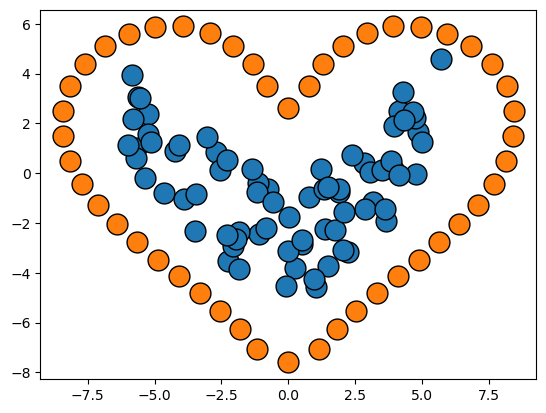

In [70]:
fig, ax = plt.subplots()

def lin_func(x):
    return abs(x) -2.0

animator = MD_animator(markersize=15, e_line=None)
num_randoms = 75
poses = np.zeros(shape=(num_randoms, 2))
for i in range(num_randoms):
    x = np.random.rand(1)*12.0 - 6.0
    y = lin_func(x=x) + np.random.rand(1)*5.0-4.0
    poses[i][0] = x
    poses[i][1] = y

atom_list_random = [Atom(position=pos) for pos in poses]
atom_col = Atom_Collection(atomlist=atom_list_left+atom_list_right+atom_list_middle+atom_list_middle1+atom_list_random)
atom_col.calculator = LennardJones()
atom_col.reset_plot_axes()
s = animator(atom_col=atom_col, ax=ax)

In [71]:
optimizer = Line_searcher1(atom_col=atom_col)
optimizer.run(track=False)

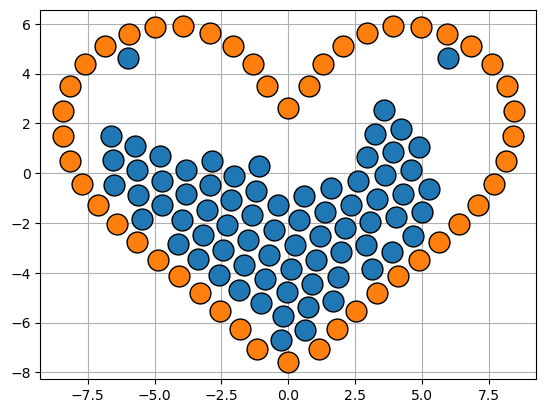

In [72]:
fig, ax = plt.subplots()
ax.grid()
opt_col = optimizer.best_atom_col
opt_col.reset_plot_axes()
s = animator(atom_col=opt_col, ax=ax)

In [75]:
atom_writer = Atom_File_handler()
atom_writer.save_atom_collections([opt_col], filename="relaxed_atom_col2")

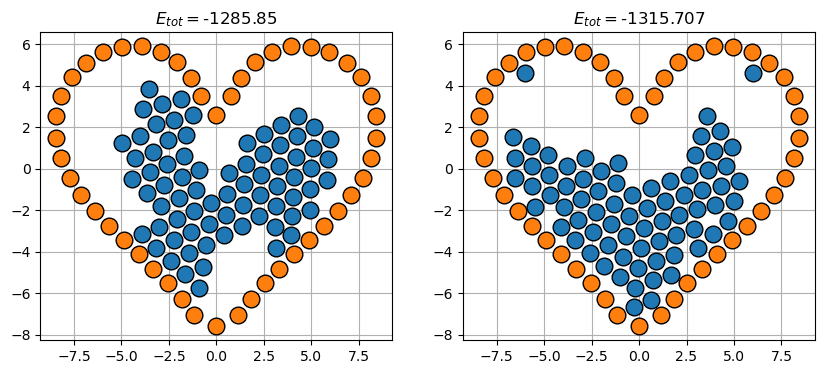

In [76]:
meta_atom_cols = [atom_writer.load_atom_collections(filename=f"relaxed_atom_col{i+1}")[0] for i in range(2)]
fig, axs = plt.subplots(1,2,figsize=(10,4))
animator = MD_animator(markersize=12, e_line=None)
for ax, meta_col in zip(axs, meta_atom_cols):
    ax.grid()
    meta_col.reset_plot_axes()
    animator(atom_col=meta_col, ax=ax)
    ax.set_title(r"$E_{tot}=$"+f"{round(meta_col.get_potential_energy(),3)}")